## Upload netcdf data to database

In [1]:
import requests
import json
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from datetime import datetime
from datetime import timedelta
from fabric import Connection
import psycopg2
import pandas.io.sql as sqlio
import getpass
from io import StringIO
import paramiko
import sys
from time import sleep
import xarray as xr
from joblib import Parallel,delayed
import glob

sys.path.insert(0, "/home/jovyan/watexr/PROGNOS/")
from prognos_tools.gce_light import gce_api as gce

key = getpass.getpass('mobiserver password: ')
vaultKey = getpass.getpass('vault password: ')
#Querying necessary tokens
def query(query,fetch=True):
    with psycopg2.connect(user='jose-luis', host='mobiserver.niva.no', port=5432, database='vault',password=key) as db:
        with db.cursor() as cursor :
            cursor.execute(query)
            if fetch:
                result = sqlio.read_sql_query(query, db)
                return result


cloudKey = json.loads(query('''select niva.getToken('gce_access','{}');'''.format(vaultKey)).iloc[0,0])
sshKey = query('''select niva.getToken('geonorway_ssh_key','{}');'''.format(vaultKey)).iloc[0,0]
not_really_a_file = StringIO(sshKey)
geo_key = paramiko.RSAKey.from_private_key(not_really_a_file)

del key,sshKey,vaultKey

mobiserver password:  ·······
vault password:  ···············


## Starting instance with database

In [2]:
#Check status of instance

#Properties of the instance containing the database
geo_props = {'project'      : 'nivacatchment',
             'zone'         : 'europe-north1-a',
             'instanceName' : "dtm10",
             'username'     : "jose-luis",
             }

#Setting up credential for google cloud
cloud = gce(geo_props, cloudKey)


#Getting instance info
cloud.CommonCalls['custom'] = '''https://compute.googleapis.com/compute/v1/projects/{project}/zones/{zone}/instances/{instanceName}'''
info = cloud.get('custom')
display(info['status'])
#If instance is stopped, start it
if info['status'] != 'RUNNING':
    cloud.CommonCalls['custom'] = '''https://compute.googleapis.com/compute/v1/projects/{project}/zones/{zone}/instances/{instanceName}/start'''
    info = cloud.post('custom')
    display(info['status'])
    cloud.CommonCalls['custom'] = '''https://compute.googleapis.com/compute/v1/projects/{project}/zones/{zone}/instances/{instanceName}'''
    info = cloud.get('custom')
    while info['status'] != 'RUNNING':
           sleep(2)
           info = cloud.get('custom')
        
del cloudKey        
   
geo_ip = info['networkInterfaces'][0]['accessConfigs'][0]['natIP']    
display(geo_ip)
geo_config =  {'host' : geo_ip, 'user': 'jose-luis', 'connect_kwargs': {'pkey': geo_key } }

#Function to query the database
def query(query,fetch=True):
    with psycopg2.connect(user='jose-luis', host=geo_ip, port=5432, database='geonorway') as db:
        with db.cursor() as cursor :
            cursor.execute(query)
            if fetch:
                result = sqlio.read_sql_query(query, db)
                return result

'RUNNING'

'35.228.213.48'

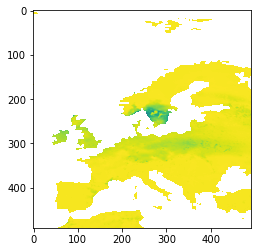

In [3]:
#Getting information for the netcdf data to be uploaded. It is assumed that all the netcdf files cover the same extent 

data = xr.load_dataset('../shared/era5-land/europe_01-01-1981.nc')
pev=data['pev']
time=data['time']
longitude=data['longitude']
latitude=data['latitude']
plt.imshow(pev[0])   

In [4]:
#Creating schema and tables to store the netcdf data
schema = 'era5land'

sql = '''drop schema if exists {schema} cascade;

create schema {schema};

create table {schema}.latitude(cid int unique primary key,latitude int unique);

create table {schema}.longitude(rid int unique primary key,longitude int unique);

create table {schema}.location(sid serial unique primary key,index int unique,
row int references {schema}.longitude(rid), 
col int references {schema}.latitude(cid), 
geom geography(polygon,4326),
point geometry(point,4326),
unique(row,col));

create table {schema}.variables(sid int references {schema}.location(index), fecha timestamptz, pet double precision, unique (sid,fecha));

insert into {schema}.longitude(rid,longitude) values {long};
insert into {schema}.latitude(cid,latitude) values {lat};

--netcdf file should be row ordered
--alter sequence serial restart with 0;
insert into {schema}.location(index,row,col) values {rc};
update {schema}.location as a
set geom = st_makeEnvelope((cast(longitude as double precision)-5)/100,
(cast(latitude as double precision)-5)/100,
(cast(longitude as double precision)+5)/100,
(cast(latitude as double precision)+5)/100,4326)
from {schema}.longitude as b, {schema}.latitude as c
where b.rid = a.row  and c.cid = a.col;

update {schema}.location as a
set point = st_setsrid(st_makePoint(cast(longitude as double precision)/100,
cast(latitude as double precision)/100),4326)
from {schema}.longitude as b, {schema}.latitude as c
where b.rid = a.row  and c.cid = a.col;

create index {schema}_location_point_idx on {schema}.location using gist(point);
create index {schema}_location_geom_idx on {schema}.location using gist(geom);

'''.format(schema=schema,
long = '(' + '),('.join(['{},{}'.format(j,i) for i,j in zip([int(round(k*100)) for k in longitude.values],range(longitude.size))]) + ')',
lat =  '(' + '),('.join(['{},{}'.format(j,i) for i,j in zip([int(round(k*100)) for k in latitude.values],range(latitude.size))]) + ')', 
rc = '(' + '),('.join(['{},{},{}'.format(c+r*longitude.size,r,c) for r in range(longitude.size) for c in range(latitude.size) ]) + ')'
)

query(sql, fetch=False)

In [ ]:
%%time
from tqdm import tqdm

#Helper function to insert netcdf data
sql = '''insert into {schema}.variables (sid,fecha,pet) values {val} on conflict do nothing;
'''
def insertDate(cnt,pev,time) : 
    nrows = pev.shape[1]
    ncols = pev.shape[2]
    to_insert = '(' + \
        '),('.join([("{},'{}-00',{}".format(col + row*ncols,
                                            time.values[cnt],
                                            pev.values[cnt,row,col] if pev.values[cnt,row,col] == pev.values[cnt,row,col] else 'Null'
                                            )
                    ) for row in range(nrows) for col in range(ncols)]  \
                  ) + \
        ')' #range(shape[0])
    query(sql.format(schema=schema,val=to_insert),fetch=False)

def insertFile(path):
    data = xr.load_dataset(path)
    pev = data['pev']
    time = data['time']
    Parallel(n_jobs=8)(delayed(insertDate)(cnt,pev,time) for cnt in range(len(time)))
    data.close()
    
    
    
#Getting list of all netcdf files and inserting them
for i in tqdm(glob.glob("/home/jovyan/shared/era5-land/europe_*.nc")):
#     display(i)
    insertFile(i)
    

# Parallel(n_jobs=8)(delayed(insertDate)(date) for date in range(shape[0]))

# with open('sql.sql','w') as f:
#     cnt = -1
#     for i in time.values[:8]:
#         cnt += 1
#         to_insert = '(' + \
#         '),('.join([("{},'{}-00',{}".format(col + row*shape[2],
#                                             i,
#                                             pev.values[cnt,row,col] if pev.values[cnt,row,col] == pev.values[cnt,row,col] else 'Null'
#                                             )
#                     ) for row in range(shape[1]) for col in range(shape[2])]  \
#                   ) + \
#         ')' #range(shape[0])
#         f.write(sql.format(schema=schema,val=to_insert))
#         f.write('\n')

# with Connection(**geo_config) as c:
#     c.put('sql.sql')
#     c.run('psql -d geonorway -f sql.sql')
#     c.run('rm sql.sql')

  8%|▊         | 1102/14611 [91:10:02<1019:11:14, 271.60s/it]

In [ ]:
# len(time)

In [ ]:
# #Checking things where properly stored
# #Getting size of raster
# a = query('''select (select count(*) from era5land.latitude) as lat, 
# (select count(*) from era5land.longitude) as long''')
# display(a)
# #Getting raster values for a given timestamptz (sid is in row major order)
# b = query('''select * from era5land.variables where fecha='1981-01-01 22:00:00-01' order by sid;''')
# b = b['pet'].values.reshape(a.loc[0,'long'],a.loc[0,'lat'])
# plt.imshow(b)

In [ ]:
display(query('''select distinct fecha from era5land.variables;'''))

In [ ]:
display(query('''select * from era5land.longitude;'''))